In [190]:
WINDOW_HOURS = 48
PCA_VARIANCE = 0.95
SEQ_LENGTH = 50
BATCH_SIZE = 64
NUM_EPOCHS = 50
EARLY_STOPPING_PATIENCE = 10  # Para após 10 épocas sem melhora

# Split Ratios (devem somar ~1.0)
TRAIN_RATIO = 0.6
VAL_RATIO = 0.12
#TEST_RATIO = X  # Calculado automaticamente: 1 - TRAIN_RATIO - VAL_RATIO

FOCAL_ALPHA = 0.75  # Aumentado para dar mais peso às falhas (classe minoritária)
FOCAL_GAMMA = 2.0

LR_CNN_LSTM = 0.0001  # Reduzido para convergência mais cuidadosa
LR_TCN = 0.0001
LR_TRANSFORMER = 0.0001

WEIGHT_DECAY = 1e-5
USE_WEIGHTED_SAMPLER = True

CNN_LSTM_FILTERS = [64, 128]
CNN_LSTM_LSTM_HIDDEN = 128
CNN_LSTM_LSTM_LAYERS = 2

TCN_CHANNELS = [64, 128, 256]
TCN_KERNEL_SIZE = 3

TRANSFORMER_D_MODEL = 128
TRANSFORMER_NHEAD = 8
TRANSFORMER_LAYERS = 3

DROPOUT = 0.3

In [191]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

warnings.filterwarnings('ignore')

In [192]:
scada = pd.read_csv("Datasets/SCADA/EDP-SCADA-2017.csv")
scada

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,...,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
0,T06,2017-12-29T20:30:00+00:00,1344.0,265.3,647.1,476.4,43.0,56,57,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39,277.4
1,T01,2017-12-29T20:30:00+00:00,289.9,238.5,265.5,13.1,40.0,54,54,54,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,285.9
2,T06,2017-12-29T20:40:00+00:00,311.0,275.0,293.1,8.9,43.0,53,54,53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38,281.2
3,T07,2017-12-29T20:40:00+00:00,1255.5,1239.3,1248.8,2.9,39.0,63,63,63,...,-143.2,-5.7,-310.4,55.3,143.2,310.4,5.7,55.3,36,290.9
4,T01,2017-12-29T20:40:00+00:00,316.0,269.4,291.4,11.5,39.0,51,51,51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34,301.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209231,T01,2017-05-31T10:50:00+00:00,1700.7,1362.5,1619.8,68.0,55.0,89,87,86,...,-998.4,-654.3,-1000.0,17.3,953.4,1000.0,443.4,95.5,65,123.8
209232,T06,2017-06-03T00:20:00+00:00,0.0,0.0,0.0,0.0,42.0,45,46,46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36,90.3
209233,T11,2017-05-31T11:10:00+00:00,1675.5,1299.7,1565.7,102.2,64.0,72,73,73,...,-1000.0,-1000.0,-1000.0,0.0,1000.0,1000.0,1000.0,0.0,53,106.6
209234,T06,2017-06-03T00:50:00+00:00,0.0,0.0,0.0,0.0,39.0,41,41,41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34,90.3


In [193]:
failure = pd.read_csv("Datasets/SCADA/EDP-Failure-2017.csv")
failure

,Turbine_ID,Component,Timestamp,Remarks
0,T01,TRANSFORMER,2017-08-11T13:14:00+00:00,Transformer fan damaged
1,T06,GEARBOX,2017-10-17T08:38:00+00:00,Gearbox bearings damaged
2,T06,HYDRAULIC_GROUP,2017-08-19T09:47:00+00:00,Oil leakage in Hub
3,T07,GENERATOR_BEARING,2017-08-20T06:08:00+00:00,Generator bearings damaged
4,T07,GENERATOR,2017-08-21T14:47:00+00:00,Generator damaged
5,T07,HYDRAULIC_GROUP,2017-06-17T11:35:00+00:00,Oil leakage in Hub
6,T07,HYDRAULIC_GROUP,2017-10-19T10:11:00+00:00,Oil leakage in Hub
7,T09,GEARBOX,2017-10-18T08:32:00+00:00,Gearbox noise
8,T09,GENERATOR_BEARING,2017-01-25T12:55:00+00:00,Generator bearings replaced
9,T09,HYDRAULIC_GROUP,2017-09-16T15:46:00+00:00,Pitch position error related GH


In [194]:
scada['Timestamp'] = pd.to_datetime(scada['Timestamp'])
failure['Timestamp'] = pd.to_datetime(failure['Timestamp'])
scada = scada.sort_values(['Turbine_ID', 'Timestamp']).reset_index(drop=True)
failure = failure.sort_values(['Turbine_ID', 'Timestamp']).reset_index(drop=True)

In [195]:
scada_cols = [col for col in scada.columns if col not in ['Timestamp', 'Turbine_ID']]
for col in scada_cols:
    scada[col] = pd.to_numeric(scada[col], errors='coerce')

Q1 = scada[scada_cols].quantile(0.01)
Q3 = scada[scada_cols].quantile(0.99)
IQR = Q3 - Q1
scada_clean = scada[~((scada[scada_cols] < (Q1 - 1.5 * IQR)) | (scada[scada_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
scada_clean[scada_cols] = scada_clean[scada_cols].fillna(scada_clean[scada_cols].median())

Normal samples: 206665
Failure samples: 2492


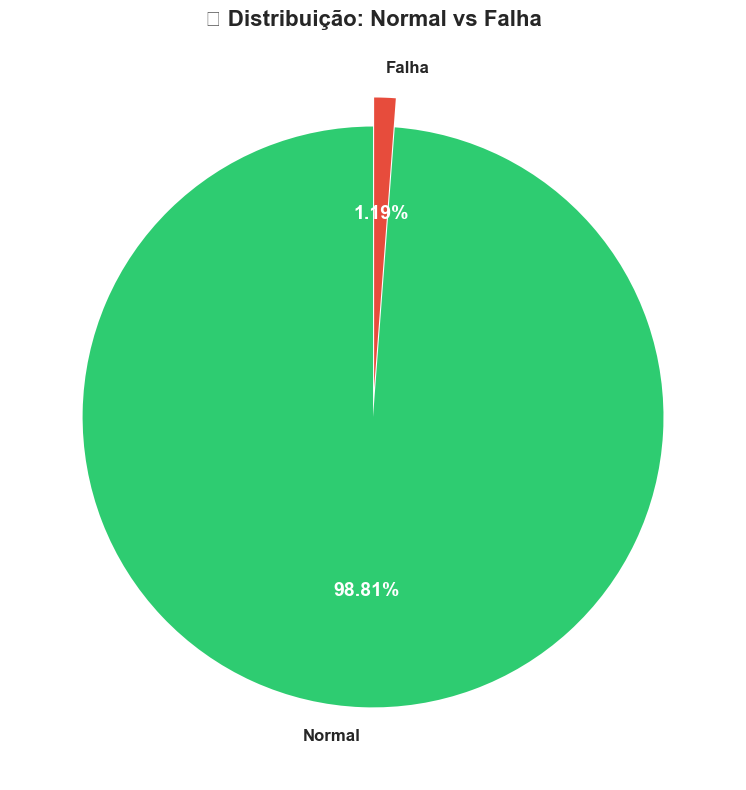


📈 Estatísticas:
Total de amostras: 209,157
Percentual de falhas: 1.19%
Desbalanceamento: 1:82 (Normal:Falha)


In [196]:
def label_data(scada_df, failure_df, window_hours=WINDOW_HOURS):
    scada_labeled = scada_df.copy()
    scada_labeled['Label'] = 0
    scada_labeled['Component'] = 'NORMAL'
    
    for _, fail_row in failure_df.iterrows():
        turbine = fail_row['Turbine_ID']
        fail_time = fail_row['Timestamp']
        component = fail_row['Component']
        
        mask = (
            (scada_labeled['Turbine_ID'] == turbine) &
            (scada_labeled['Timestamp'] <= fail_time) &
            (scada_labeled['Timestamp'] >= fail_time - pd.Timedelta(hours=window_hours))
        )
        scada_labeled.loc[mask, 'Label'] = 1
        scada_labeled.loc[mask, 'Component'] = component
    
    return scada_labeled

scada_labeled = label_data(scada_clean, failure)
print(f"Normal samples: {(scada_labeled['Label']==0).sum()}")
print(f"Failure samples: {(scada_labeled['Label']==1).sum()}")

# Visualização da distribuição Normal vs Falha
fig, ax = plt.subplots(figsize=(8, 8))
labels_count = scada_labeled['Label'].value_counts()
labels_names = ['Normal', 'Falha']
colors = ['#2ecc71', '#e74c3c']
explode = (0, 0.1)  # Destaca a fatia de falhas

wedges, texts, autotexts = ax.pie(labels_count.values, 
                                    labels=labels_names, 
                                    autopct='%1.2f%%',
                                    colors=colors,
                                    explode=explode,
                                    startangle=90,
                                    textprops={'fontsize': 12, 'weight': 'bold'})

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)

ax.set_title('📊 Distribuição: Normal vs Falha', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"\n📈 Estatísticas:")
print(f"Total de amostras: {len(scada_labeled):,}")
print(f"Percentual de falhas: {(scada_labeled['Label']==1).sum() / len(scada_labeled) * 100:.2f}%")
print(f"Desbalanceamento: 1:{int((scada_labeled['Label']==0).sum() / (scada_labeled['Label']==1).sum())} (Normal:Falha)")

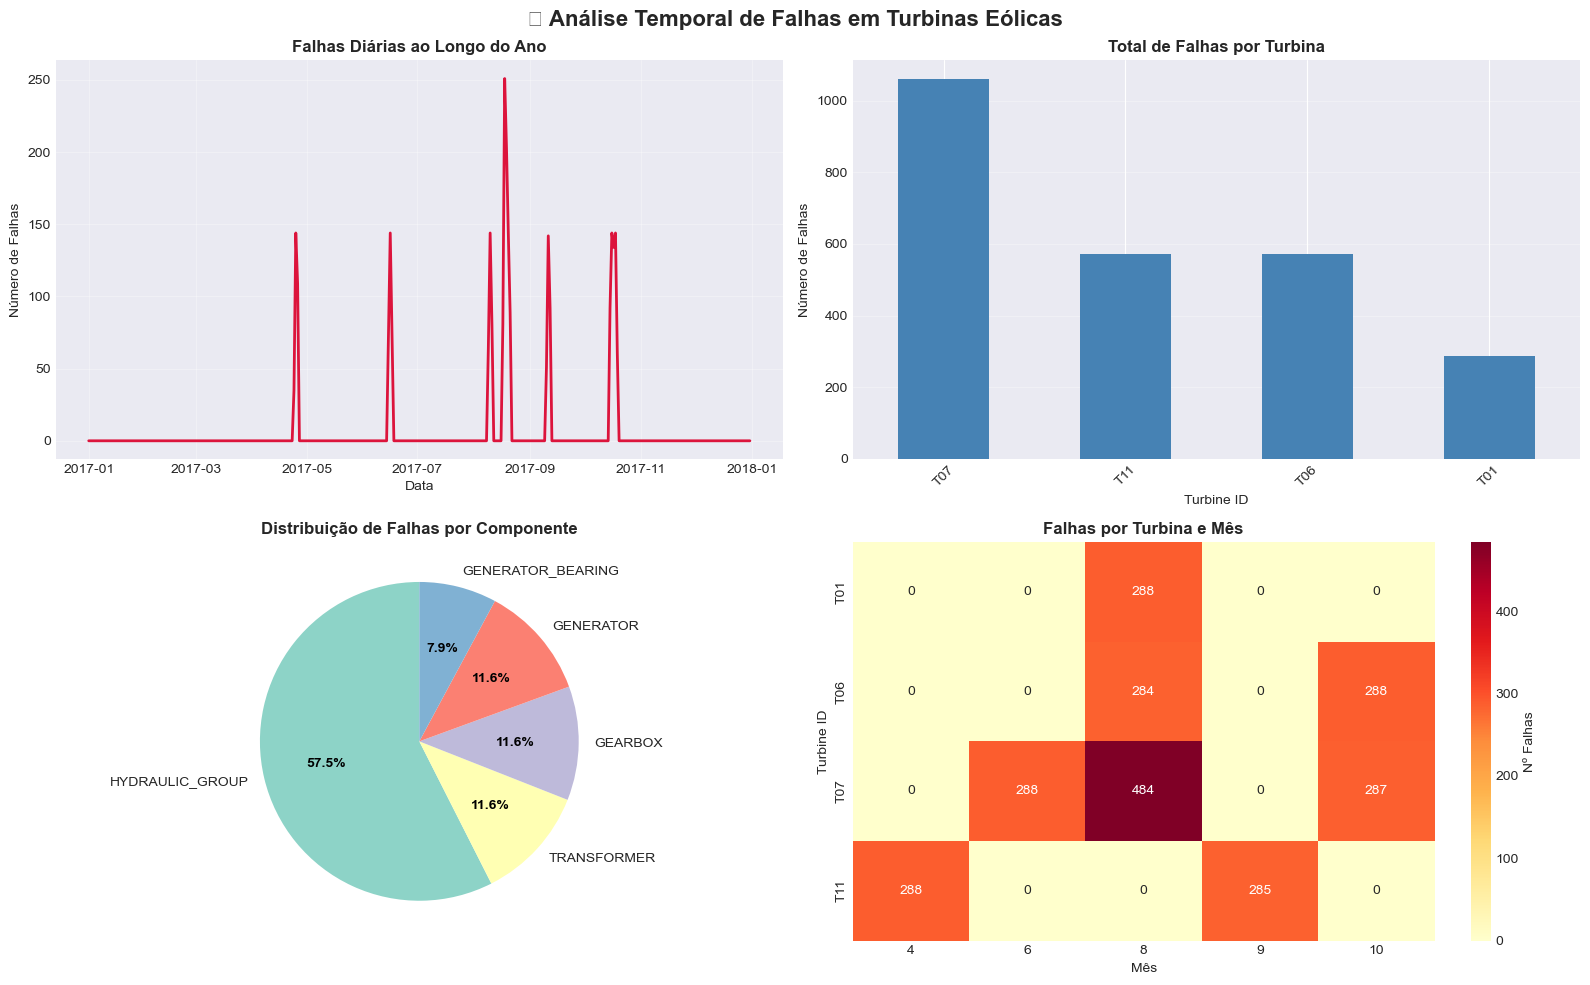


📈 ESTATÍSTICAS DE FALHAS:
Total de registros: 209,157
Total de falhas: 2,492
Percentual de falhas: 1.19%

Turbina com mais falhas: TT07 (1059 falhas)
Turbina com menos falhas: TT01 (288 falhas)

Componente mais crítico: HYDRAULIC_GROUP (1432 ocorrências)
Total de componentes afetados: 5


In [197]:
# Criar figura com subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('📊 Análise Temporal de Falhas em Turbinas Eólicas', fontsize=16, fontweight='bold')

# Criar cópia temporária para não modificar o DataFrame original
scada_viz = scada_labeled.copy()
scada_viz['Date'] = scada_viz['Timestamp'].dt.date
scada_viz['Month'] = scada_viz['Timestamp'].dt.month

# 1. Distribuição de Falhas ao Longo do Tempo (Geral)
ax1 = axes[0, 0]
daily_failures = scada_viz.groupby('Date')['Label'].sum()
daily_failures.plot(ax=ax1, color='crimson', linewidth=2)
ax1.set_title('Falhas Diárias ao Longo do Ano', fontsize=12, fontweight='bold')
ax1.set_xlabel('Data', fontsize=10)
ax1.set_ylabel('Número de Falhas', fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Distribuição por Turbina
ax2 = axes[0, 1]
turbine_failures = scada_viz.groupby('Turbine_ID')['Label'].sum().sort_values(ascending=False)
turbine_failures.plot(kind='bar', ax=ax2, color='steelblue')
ax2.set_title('Total de Falhas por Turbina', fontsize=12, fontweight='bold')
ax2.set_xlabel('Turbine ID', fontsize=10)
ax2.set_ylabel('Número de Falhas', fontsize=10)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Distribuição por Componente
ax3 = axes[1, 0]
component_failures = scada_viz[scada_viz['Label']==1]['Component'].value_counts()
colors = plt.cm.Set3(range(len(component_failures)))
wedges, texts, autotexts = ax3.pie(component_failures.values, labels=component_failures.index, 
                                     autopct='%1.1f%%', colors=colors, startangle=90)
ax3.set_title('Distribuição de Falhas por Componente', fontsize=12, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')

# 4. Heatmap de Falhas (Turbina x Mês)
ax4 = axes[1, 1]
heatmap_data = scada_viz[scada_viz['Label']==1].groupby(['Turbine_ID', 'Month']).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, ax=ax4, cmap='YlOrRd', annot=True, fmt='d', cbar_kws={'label': 'Nº Falhas'})
ax4.set_title('Falhas por Turbina e Mês', fontsize=12, fontweight='bold')
ax4.set_xlabel('Mês', fontsize=10)
ax4.set_ylabel('Turbine ID', fontsize=10)

plt.tight_layout()
plt.show()

# Estatísticas adicionais
print("\n📈 ESTATÍSTICAS DE FALHAS:")
print("="*50)
print(f"Total de registros: {len(scada_labeled):,}")
print(f"Total de falhas: {(scada_labeled['Label']==1).sum():,}")
print(f"Percentual de falhas: {(scada_labeled['Label']==1).sum() / len(scada_labeled) * 100:.2f}%")
print(f"\nTurbina com mais falhas: T{turbine_failures.index[0]} ({turbine_failures.values[0]} falhas)")
print(f"Turbina com menos falhas: T{turbine_failures.index[-1]} ({turbine_failures.values[-1]} falhas)")
print(f"\nComponente mais crítico: {component_failures.index[0]} ({component_failures.values[0]} ocorrências)")
print(f"Total de componentes afetados: {len(component_failures)}")

In [198]:
feature_cols = [col for col in scada_labeled.columns if col not in ['Timestamp', 'Turbine_ID', 'Label', 'Component']]
X = scada_labeled[feature_cols].values
y = scada_labeled['Label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=PCA_VARIANCE, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"Original features: {X.shape[1]}, PCA features: {X_pca.shape[1]}")

Original features: 81, PCA features: 16


In [199]:
def create_sequences(X, y, turbine_ids, seq_length=50):
    sequences = []
    labels = []
    seq_turbine_ids = []
    
    unique_turbines = np.unique(turbine_ids)
    for turbine in unique_turbines:
        turbine_mask = turbine_ids == turbine
        X_turbine = X[turbine_mask]
        y_turbine = y[turbine_mask]
        
        for i in range(len(X_turbine) - seq_length + 1):
            sequences.append(X_turbine[i:i+seq_length])
            labels.append(y_turbine[i+seq_length-1])
            seq_turbine_ids.append(turbine)
    
    return np.array(sequences), np.array(labels), np.array(seq_turbine_ids)

turbine_ids_original = scada_labeled['Turbine_ID'].values
X_seq, y_seq, turbine_ids = create_sequences(X_pca, y, turbine_ids_original, SEQ_LENGTH)
print(f"Sequences shape: {X_seq.shape}, Labels shape: {y_seq.shape}, Turbine IDs: {len(turbine_ids)}")

Sequences shape: (208961, 50, 16), Labels shape: (208961,), Turbine IDs: 208961


In [200]:
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42, stratify=y_seq)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (146272, 50, 16), Val: (31344, 50, 16), Test: (31345, 50, 16)


In [201]:
def temporal_train_test_split(X, y, turbine_ids, train_ratio=0.7, val_ratio=0.15):
    X_train_list, y_train_list = [], []
    X_val_list, y_val_list = [], []
    X_test_list, y_test_list = [], []
    
    unique_turbines = np.unique(turbine_ids)
    for turbine in unique_turbines:
        turbine_mask = turbine_ids == turbine
        X_turbine = X[turbine_mask]
        y_turbine = y[turbine_mask]
        
        n_samples = len(X_turbine)
        train_idx = int(n_samples * train_ratio)
        val_idx = int(n_samples * (train_ratio + val_ratio))
        
        X_train_list.append(X_turbine[:train_idx])
        y_train_list.append(y_turbine[:train_idx])
        
        X_val_list.append(X_turbine[train_idx:val_idx])
        y_val_list.append(y_turbine[train_idx:val_idx])
        
        X_test_list.append(X_turbine[val_idx:])
        y_test_list.append(y_turbine[val_idx:])
    
    return (np.vstack(X_train_list), np.concatenate(y_train_list),
            np.vstack(X_val_list), np.concatenate(y_val_list),
            np.vstack(X_test_list), np.concatenate(y_test_list))

print("IMPORTANTE: Usando split TEMPORAL para evitar vazamento de dados!")
print(f"Cada turbina é dividida cronologicamente: {TRAIN_RATIO*100:.0f}% treino, {VAL_RATIO*100:.0f}% validação, {(1-TRAIN_RATIO-VAL_RATIO)*100:.0f}% teste\n")

X_train_temp, y_train_temp, X_val_temp, y_val_temp, X_test_temp, y_test_temp = temporal_train_test_split(
    X_seq, y_seq, turbine_ids, train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO
)

print(f"Train: {X_train_temp.shape}, Val: {X_val_temp.shape}, Test: {X_test_temp.shape}")
print(f"Train labels - Normal: {(y_train_temp==0).sum()}, Failure: {(y_train_temp==1).sum()}")
print(f"Val labels - Normal: {(y_val_temp==0).sum()}, Failure: {(y_val_temp==1).sum()}")
print(f"Test labels - Normal: {(y_test_temp==0).sum()}, Failure: {(y_test_temp==1).sum()}")

print(f"\nDistribuição percentual de falhas:")
print(f"Train: {(y_train_temp==1).sum() / len(y_train_temp) * 100:.2f}% falhas")
print(f"Val: {(y_val_temp==1).sum() / len(y_val_temp) * 100:.2f}% falhas")
print(f"Test: {(y_test_temp==1).sum() / len(y_test_temp) * 100:.2f}% falhas")

if (y_val_temp==1).sum() == 0 or (y_test_temp==1).sum() == 0:
    print("\n⚠️ AVISO: Um dos conjuntos (Val ou Test) NÃO TEM FALHAS!")
    print("Isso é um problema sério para avaliação. Considere:")
    print("1. Aumentar WINDOW_HOURS para rotular mais dados como falha")
    print("2. Usar split estratificado por turbina")
    print("3. Ajustar os ratios do split (train_ratio, val_ratio)")


IMPORTANTE: Usando split TEMPORAL para evitar vazamento de dados!
Cada turbina é dividida cronologicamente: 60% treino, 12% validação, 28% teste

Train: (125375, 50, 16), Val: (25076, 50, 16), Test: (58510, 50, 16)
Train labels - Normal: 124799, Failure: 576
Val labels - Normal: 23735, Failure: 1341
Test labels - Normal: 57935, Failure: 575

Distribuição percentual de falhas:
Train: 0.46% falhas
Val: 5.35% falhas
Test: 0.98% falhas
Train: (125375, 50, 16), Val: (25076, 50, 16), Test: (58510, 50, 16)
Train labels - Normal: 124799, Failure: 576
Val labels - Normal: 23735, Failure: 1341
Test labels - Normal: 57935, Failure: 575

Distribuição percentual de falhas:
Train: 0.46% falhas
Val: 5.35% falhas
Test: 0.98% falhas


In [202]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ⚠️ USANDO SPLIT TEMPORAL PARA EVITAR VAZAMENTO DE DADOS
print("🔄 Criando DataLoaders com SPLIT TEMPORAL (sem vazamento de dados)...")
X_train_tensor = torch.FloatTensor(X_train_temp)
y_train_tensor = torch.LongTensor(y_train_temp)
X_val_tensor = torch.FloatTensor(X_val_temp)
y_val_tensor = torch.LongTensor(y_val_temp)
X_test_tensor = torch.FloatTensor(X_test_temp)
y_test_tensor = torch.LongTensor(y_test_temp)

train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
val_dataset = TimeSeriesDataset(X_val_tensor, y_val_tensor)
test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)

class_counts = np.bincount(y_train_temp)
class_weights = 1. / class_counts
sample_weights = class_weights[y_train_temp]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

if USE_WEIGHTED_SAMPLER:
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
else:
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ DataLoaders criados com dados TEMPORAIS!")
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

🔄 Criando DataLoaders com SPLIT TEMPORAL (sem vazamento de dados)...
✅ DataLoaders criados com dados TEMPORAIS!
Train samples: 125375, Val samples: 25076, Test samples: 58510
✅ DataLoaders criados com dados TEMPORAIS!
Train samples: 125375, Val samples: 25076, Test samples: 58510


In [203]:
print("="*70)
print("🔍 VERIFICAÇÃO CRÍTICA: Test Set tem falhas suficientes?")
print("="*70)

test_failures = (y_test_temp==1).sum()
test_total = len(y_test_temp)
test_failure_pct = test_failures / test_total * 100

print(f"Test Set: {test_failures} falhas / {test_total} amostras ({test_failure_pct:.2f}%)")

if test_failures == 0:
    print("\n❌ PROBLEMA CRÍTICO: Test Set NÃO TEM FALHAS!")
    print("Não é possível avaliar o modelo sem falhas no Test Set.")
    print("\n💡 SOLUÇÕES:")
    print("1. Aumentar WINDOW_HOURS (ex: 48h ou 72h) - rotula mais dados como falha")
    print("2. Ajustar split ratios (ex: train=0.6, val=0.2, test=0.2)")
    print("3. Usar GroupKFold para garantir falhas em todos os folds")
    print("\n⚠️ PARE AQUI e ajuste os parâmetros antes de treinar!")
elif test_failures < 50:
    print(f"\n⚠️ AVISO: Test Set tem POUCAS falhas ({test_failures})")
    print("Métricas podem ser instáveis. Considere aumentar WINDOW_HOURS.")
else:
    print(f"\n✅ OK: Test Set tem {test_failures} falhas - suficiente para avaliação!")

print("="*70)

🔍 VERIFICAÇÃO CRÍTICA: Test Set tem falhas suficientes?
Test Set: 575 falhas / 58510 amostras (0.98%)

✅ OK: Test Set tem 575 falhas - suficiente para avaliação!


In [204]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, class_weights=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.class_weights = class_weights
        
    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none', weight=self.class_weights)(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [205]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_dim, seq_length, num_classes=2):
        super(CNN_LSTM, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.3)
        
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=2, 
                           batch_first=True, dropout=0.3, bidirectional=True)
        
        self.fc1 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = x.transpose(1, 2)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = x.transpose(1, 2)
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]
        
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x

In [206]:
class TCN(nn.Module):
    def __init__(self, input_dim, num_channels=[64, 128, 256], kernel_size=3, dropout=0.3, num_classes=2):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_dim if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            
            padding = (kernel_size - 1) * dilation_size
            layers += [nn.Conv1d(in_channels, out_channels, kernel_size, 
                                 stride=1, padding=padding, dilation=dilation_size),
                      nn.BatchNorm1d(out_channels),
                      nn.ReLU(),
                      nn.Dropout(dropout)]
        
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], num_classes)
        
    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.network(x)
        x = x[:, :, -1]
        x = self.fc(x)
        return x

In [207]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=3, dropout=0.3, num_classes=2):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.randn(1, 1000, d_model))
        
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, 
                                                     dim_feedforward=512, dropout=dropout, 
                                                     batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        self.fc = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        seq_len = x.size(1)
        x = self.embedding(x)
        x = x + self.pos_encoder[:, :seq_len, :]
        x = self.dropout(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

In [208]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device='cuda', patience=10):
    model.to(device)
    best_val_f1 = 0.0
    best_model_state = None
    epochs_without_improvement = 0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'val_precision': [], 'val_recall': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(y_batch.cpu().numpy())
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_f1 = f1_score(val_labels, val_preds, average='binary')
        val_precision = precision_score(val_labels, val_preds, average='binary', zero_division=0)
        val_recall = recall_score(val_labels, val_preds, average='binary', zero_division=0)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        
        # Early Stopping baseado em F1-Score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
            epochs_without_improvement = 0
            improvement_marker = "⭐"
        else:
            epochs_without_improvement += 1
            improvement_marker = ""
        
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"F1: {val_f1:.4f} | Precision: {val_precision:.4f} | Recall: {val_recall:.4f} {improvement_marker}")
        
        # Early Stopping
        if epochs_without_improvement >= patience:
            print(f"\n⚠️ Early Stopping! Sem melhora por {patience} épocas.")
            print(f"Melhor F1-Score: {best_val_f1:.4f} (época {epoch+1-patience})")
            break
    
    # Restaura melhor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n✅ Modelo restaurado com melhor F1-Score: {best_val_f1:.4f}")
    else:
        print(f"\n⚠️ Nenhuma melhora detectada. F1 final: {best_val_f1:.4f}")
    
    return model, history

In [209]:
def evaluate_model(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())
            all_probs.extend(probs)
    
    f1 = f1_score(all_labels, all_preds, average='binary')
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'auc_roc': auc,
        'confusion_matrix': cm
    }

In [210]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

input_dim = X_pca.shape[1]
seq_length = SEQ_LENGTH

# Calcular class weights baseado na distribuição do treino
class_counts_train = np.bincount(y_train_temp)
class_weights_values = len(y_train_temp) / (len(class_counts_train) * class_counts_train)
class_weights_tensor = torch.FloatTensor(class_weights_values).to(device)

print(f"\n⚙️ Class Weights Calculados:")
print(f"   Classe 0 (Normal): {class_weights_values[0]:.4f}")
print(f"   Classe 1 (Falha): {class_weights_values[1]:.4f}")
print(f"   Razão (Falha/Normal): {class_weights_values[1]/class_weights_values[0]:.2f}x\n")

model_cnn_lstm = CNN_LSTM(input_dim=input_dim, seq_length=seq_length)
criterion = FocalLoss(alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA, class_weights=class_weights_tensor)
optimizer = optim.Adam(model_cnn_lstm.parameters(), lr=LR_CNN_LSTM, weight_decay=WEIGHT_DECAY)

print("Training CNN-LSTM Model...")
model_cnn_lstm, history_cnn_lstm = train_model(model_cnn_lstm, train_loader, val_loader, 
                                                 criterion, optimizer, num_epochs=NUM_EPOCHS,
                                                 device=device, patience=EARLY_STOPPING_PATIENCE)

Using device: cuda

⚙️ Class Weights Calculados:
   Classe 0 (Normal): 0.5023
   Classe 1 (Falha): 108.8325
   Razão (Falha/Normal): 216.66x

Training CNN-LSTM Model...

⚙️ Class Weights Calculados:
   Classe 0 (Normal): 0.5023
   Classe 1 (Falha): 108.8325
   Razão (Falha/Normal): 216.66x

Training CNN-LSTM Model...
Epoch [  1/50] | Train Loss: 0.8130 | Val Loss: 5.8288 | F1: 0.1339 | Precision: 0.0974 | Recall: 0.2140 ⭐
Epoch [  1/50] | Train Loss: 0.8130 | Val Loss: 5.8288 | F1: 0.1339 | Precision: 0.0974 | Recall: 0.2140 ⭐
Epoch [  2/50] | Train Loss: 0.0445 | Val Loss: 8.9383 | F1: 0.1359 | Precision: 0.1418 | Recall: 0.1305 ⭐
Epoch [  2/50] | Train Loss: 0.0445 | Val Loss: 8.9383 | F1: 0.1359 | Precision: 0.1418 | Recall: 0.1305 ⭐
Epoch [  3/50] | Train Loss: 0.0283 | Val Loss: 8.8965 | F1: 0.1162 | Precision: 0.0935 | Recall: 0.1536 
Epoch [  3/50] | Train Loss: 0.0283 | Val Loss: 8.8965 | F1: 0.1162 | Precision: 0.0935 | Recall: 0.1536 
Epoch [  4/50] | Train Loss: 0.0127 | Val

In [211]:
print("\nEvaluating CNN-LSTM Model on Test Set:")
results_cnn_lstm = evaluate_model(model_cnn_lstm, test_loader, device)
print(f"F1-Score: {results_cnn_lstm['f1_score']:.4f}")
print(f"Precision: {results_cnn_lstm['precision']:.4f}")
print(f"Recall: {results_cnn_lstm['recall']:.4f}")
print(f"AUC-ROC: {results_cnn_lstm['auc_roc']:.4f}")
print(f"Confusion Matrix:\n{results_cnn_lstm['confusion_matrix']}")


Evaluating CNN-LSTM Model on Test Set:
F1-Score: 0.0000
Precision: 0.0000
Recall: 0.0000
AUC-ROC: 0.4508
Confusion Matrix:
[[57862    73]
 [  575     0]]
F1-Score: 0.0000
Precision: 0.0000
Recall: 0.0000
AUC-ROC: 0.4508
Confusion Matrix:
[[57862    73]
 [  575     0]]


In [212]:
model_tcn = TCN(input_dim=input_dim, num_channels=TCN_CHANNELS, kernel_size=TCN_KERNEL_SIZE, dropout=DROPOUT)
criterion_tcn = FocalLoss(alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA, class_weights=class_weights_tensor)
optimizer_tcn = optim.Adam(model_tcn.parameters(), lr=LR_TCN, weight_decay=WEIGHT_DECAY)

print("Training TCN Model...")
model_tcn, history_tcn = train_model(model_tcn, train_loader, val_loader, 
                                      criterion_tcn, optimizer_tcn, num_epochs=NUM_EPOCHS,
                                      device=device, patience=EARLY_STOPPING_PATIENCE)

Training TCN Model...
Epoch [  1/50] | Train Loss: 0.8435 | Val Loss: 1.4905 | F1: 0.1065 | Precision: 0.0563 | Recall: 0.9911 ⭐
Epoch [  1/50] | Train Loss: 0.8435 | Val Loss: 1.4905 | F1: 0.1065 | Precision: 0.0563 | Recall: 0.9911 ⭐
Epoch [  2/50] | Train Loss: 0.4016 | Val Loss: 3.4367 | F1: 0.1015 | Precision: 0.0544 | Recall: 0.7487 
Epoch [  2/50] | Train Loss: 0.4016 | Val Loss: 3.4367 | F1: 0.1015 | Precision: 0.0544 | Recall: 0.7487 
Epoch [  3/50] | Train Loss: 0.2915 | Val Loss: 4.8824 | F1: 0.1032 | Precision: 0.0555 | Recall: 0.7360 
Epoch [  3/50] | Train Loss: 0.2915 | Val Loss: 4.8824 | F1: 0.1032 | Precision: 0.0555 | Recall: 0.7360 
Epoch [  4/50] | Train Loss: 0.2459 | Val Loss: 10.4338 | F1: 0.1093 | Precision: 0.0604 | Recall: 0.5705 ⭐
Epoch [  4/50] | Train Loss: 0.2459 | Val Loss: 10.4338 | F1: 0.1093 | Precision: 0.0604 | Recall: 0.5705 ⭐
Epoch [  5/50] | Train Loss: 0.2213 | Val Loss: 11.9476 | F1: 0.1105 | Precision: 0.0616 | Recall: 0.5369 ⭐
Epoch [  5/50] |

In [213]:
print("\nEvaluating TCN Model on Test Set:")
results_tcn = evaluate_model(model_tcn, test_loader, device)
print(f"F1-Score: {results_tcn['f1_score']:.4f}")
print(f"Precision: {results_tcn['precision']:.4f}")
print(f"Recall: {results_tcn['recall']:.4f}")
print(f"AUC-ROC: {results_tcn['auc_roc']:.4f}")
print(f"Confusion Matrix:\n{results_tcn['confusion_matrix']}")


Evaluating TCN Model on Test Set:
F1-Score: 0.0285
Precision: 0.0153
Recall: 0.2017
AUC-ROC: 0.6310
Confusion Matrix:
[[50490  7445]
 [  459   116]]
F1-Score: 0.0285
Precision: 0.0153
Recall: 0.2017
AUC-ROC: 0.6310
Confusion Matrix:
[[50490  7445]
 [  459   116]]


In [214]:
model_transformer = TransformerModel(input_dim=input_dim, d_model=TRANSFORMER_D_MODEL, nhead=TRANSFORMER_NHEAD, num_layers=TRANSFORMER_LAYERS, dropout=DROPOUT)
criterion_transformer = FocalLoss(alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA, class_weights=class_weights_tensor)
optimizer_transformer = optim.Adam(model_transformer.parameters(), lr=LR_TRANSFORMER, weight_decay=WEIGHT_DECAY)

print("Training Transformer Model...")
model_transformer, history_transformer = train_model(model_transformer, train_loader, val_loader, 
                                                       criterion_transformer, optimizer_transformer, num_epochs=NUM_EPOCHS,
                                                       device=device, patience=EARLY_STOPPING_PATIENCE)

Training Transformer Model...
Epoch [  1/50] | Train Loss: 0.4143 | Val Loss: 5.3085 | F1: 0.1306 | Precision: 0.0748 | Recall: 0.5130 ⭐
Epoch [  1/50] | Train Loss: 0.4143 | Val Loss: 5.3085 | F1: 0.1306 | Precision: 0.0748 | Recall: 0.5130 ⭐
Epoch [  2/50] | Train Loss: 0.0656 | Val Loss: 18.2379 | F1: 0.1027 | Precision: 0.0758 | Recall: 0.1588 
Epoch [  2/50] | Train Loss: 0.0656 | Val Loss: 18.2379 | F1: 0.1027 | Precision: 0.0758 | Recall: 0.1588 
Epoch [  3/50] | Train Loss: 0.0543 | Val Loss: 15.2005 | F1: 0.1019 | Precision: 0.0688 | Recall: 0.1969 
Epoch [  3/50] | Train Loss: 0.0543 | Val Loss: 15.2005 | F1: 0.1019 | Precision: 0.0688 | Recall: 0.1969 
Epoch [  4/50] | Train Loss: 0.0378 | Val Loss: 22.1197 | F1: 0.1075 | Precision: 0.0907 | Recall: 0.1320 
Epoch [  4/50] | Train Loss: 0.0378 | Val Loss: 22.1197 | F1: 0.1075 | Precision: 0.0907 | Recall: 0.1320 
Epoch [  5/50] | Train Loss: 0.0346 | Val Loss: 21.6921 | F1: 0.1099 | Precision: 0.0904 | Recall: 0.1402 
Epoch [

In [215]:
print("\nEvaluating Transformer Model on Test Set:")
results_transformer = evaluate_model(model_transformer, test_loader, device)
print(f"F1-Score: {results_transformer['f1_score']:.4f}")
print(f"Precision: {results_transformer['precision']:.4f}")
print(f"Recall: {results_transformer['recall']:.4f}")
print(f"AUC-ROC: {results_transformer['auc_roc']:.4f}")
print(f"Confusion Matrix:\n{results_transformer['confusion_matrix']}")


Evaluating Transformer Model on Test Set:
F1-Score: 0.0000
Precision: 0.0000
Recall: 0.0000
AUC-ROC: 0.3559
Confusion Matrix:
[[57490   445]
 [  575     0]]
F1-Score: 0.0000
Precision: 0.0000
Recall: 0.0000
AUC-ROC: 0.3559
Confusion Matrix:
[[57490   445]
 [  575     0]]


In [216]:
print("\n" + "="*60)
print("MODEL COMPARISON - TEST SET RESULTS")
print("="*60)

models_results = {
    'CNN-LSTM': results_cnn_lstm,
    'TCN': results_tcn,
    'Transformer': results_transformer
}

comparison_df = pd.DataFrame({
    'Model': list(models_results.keys()),
    'F1-Score': [r['f1_score'] for r in models_results.values()],
    'Precision': [r['precision'] for r in models_results.values()],
    'Recall': [r['recall'] for r in models_results.values()],
    'AUC-ROC': [r['auc_roc'] for r in models_results.values()]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)
print(comparison_df.to_string(index=False))


MODEL COMPARISON - TEST SET RESULTS
      Model  F1-Score  Precision   Recall  AUC-ROC
        TCN  0.028515   0.015342 0.201739 0.631027
   CNN-LSTM  0.000000   0.000000 0.000000 0.450845
Transformer  0.000000   0.000000 0.000000 0.355871
